<a href="https://colab.research.google.com/github/artoowang/ray_tracer_colab/blob/main/Ray_Tracer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ray Tracer in Colab

This is a Colab setup to build and run a C++ ray tracer implementation forked from https://raytracing.github.io/. A thin Python/Cython layer is created to run the C++ code, and display the rendered image in the notebook. This allows both the high performance from C++ code and the flexibility of Python/Colab, but at the cost of requiring some Cython code to interface between them.

## Cython module build setup

The Cython module is created and linked with the C++ code. A setup script `ray_tracer_wrapper_setup.py` is used to build the `ray_tracer_wrapper` module. However, since Python runtime caches a loaded module, I use my [`cython_colab`](https://github.com/artoowang/cython_colab) module to manually build and load the Cython module.

## Directory structure

The C++ sources are stored in the [`ray_tracer_colab`](https://github.com/artoowang/ray_tracer_colab) repo, and it will be checked out to the working directory of the Colab runtime in the initialization cell below.

When running the Colab runtime locally, it is also possible to manually check out the `ray_tracer_colab` repo under exactly that name. If such directory exists, initialization will use that directory and skip the checking out. This allows changing the C++ code locally (e.g., in a terminal) and rebuild the Cython module in this notebook to pick up the changes, which is useful for development.

## Initialization

In [2]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

%reload_ext Cython

imageio.plugins.freeimage.download()

In [3]:
if os.path.exists('ray_tracer_colab'):
  print('Use local ray_tracer_colab repo.')
else:
  print('Checking out ray_tracer_colab repo ...')
  !git clone https://github.com/artoowang/ray_tracer_colab.git

Use local ray_tracer_colab repo.


## Run

### ray_tracer_main.h

In [3]:
%%file ray_tracer_main.h

#ifndef RAY_TRACER_MAIN_H
#define RAY_TRACER_MAIN_H

#include "camera.h"
#include "hittable_list.h"
#include "scene.h"

Scene CreateScene(int image_width, int image_height);

#endif  // RAY_TRACER_MAIN_H

Overwriting ray_tracer_main.h


### ray_tracer_main.cc

In [4]:
%%file ray_tracer_main.cc

#include "ray_tracer_main.h"

#include <fstream>
#include <iostream>
#include <utility>

#include "rtweekend.h"
#include "color.h"
#include "material.h"
#include "sphere.h"

hittable_list CreateRandomWorld() {
    hittable_list world;

    auto ground_material = make_shared<lambertian>(color(0.5, 0.5, 0.5));
    world.add(make_shared<sphere>(point3(0,-1000,0), 1000, ground_material));

    for (int a = -11; a < 11; a++) {
        for (int b = -11; b < 11; b++) {
            auto choose_mat = random_double();
            point3 center(a + 0.9*random_double(), 0.2, b + 0.9*random_double());

            if ((center - point3(4, 0.2, 0)).length() > 0.9) {
                shared_ptr<material> sphere_material;

                if (choose_mat < 0.8) {
                    // diffuse
                    auto albedo = color::random() * color::random();
                    sphere_material = make_shared<lambertian>(albedo);
                    world.add(make_shared<sphere>(center, 0.2, sphere_material));
                } else if (choose_mat < 0.95) {
                    // metal
                    auto albedo = color::random(0.5, 1);
                    auto fuzz = random_double(0, 0.5);
                    sphere_material = make_shared<metal>(albedo, fuzz);
                    world.add(make_shared<sphere>(center, 0.2, sphere_material));
                } else {
                    // glass
                    sphere_material = make_shared<dielectric>(1.5);
                    world.add(make_shared<sphere>(center, 0.2, sphere_material));
                }
            }
        }
    }

    auto material1 = make_shared<dielectric>(1.5);
    world.add(make_shared<sphere>(point3(0, 1, 0), 1.0, material1));

    auto material2 = make_shared<lambertian>(color(0.4, 0.2, 0.1));
    world.add(make_shared<sphere>(point3(-4, 1, 0), 1.0, material2));

    auto material3 = make_shared<metal>(color(0.7, 0.6, 0.5), 0.0);
    world.add(make_shared<sphere>(point3(4, 1, 0), 1.0, material3));

    return world;
}

Scene CreateScene(int image_width, int image_height) {
  point3 lookfrom(13,2,3);
  point3 lookat(0,0,0);
  vec3 vup(0,1,0);
  auto dist_to_focus = 10.0;
  auto aperture = 0.1;
  const double aspect_ratio = static_cast<double>(image_width) / image_height;
  Camera camera(lookfrom, lookat, vup, 20, aspect_ratio, aperture, dist_to_focus);
  return Scene(image_width, image_height,
               /*samples_per_pixel=*/10,
               /*max_depth=*/50, CreateRandomWorld(), std::move(camera));
}

Overwriting ray_tracer_main.cc


### ray_tracer_main.pxd

In [5]:
%%file ray_tracer_main.pxd

from ray_tracer_colab.pxd.scene cimport Scene

cdef extern from 'ray_tracer_main.h':
  Scene CreateScene(int image_width, int image_height)

Overwriting ray_tracer_main.pxd


### Run

  0%|          | 0/180 [00:00<?, ?it/s]

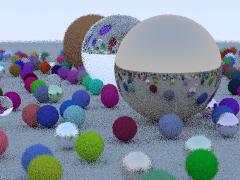

In [4]:
%%cython -3 -I. -Iray_tracer_colab/include -f -c=-std=c++17 --cplus -S ray_tracer_colab/src/scene.cc -S ray_tracer_main.cc -c=-Wno-unreachable-code -c=-Wp,-fopenmp --link-args=-lomp --link-args=-Wp,-fopenmp

import cython
import numpy as np
import time

from IPython import display
from PIL import Image
from cython.parallel import prange, threadid
from tqdm.notebook import tqdm

from ray_tracer_colab.utils.preview_display import PreviewDisplay

from libc.stdint cimport uint8_t

from ray_tracer_colab.pxd.scene cimport Scene
from ray_tracer_main cimport CreateScene


def run_parallel(Py_ssize_t image_width, Py_ssize_t image_height):
  # Create the bytearray to hold the ray tracer output.
  cdef bytearray buffer = bytearray(image_width * image_height * 3)
  # We need to explicitly declare a uint8_t pointer because we cannot access
  # bytearray within prange().
  cdef uint8_t* ptr = buffer
  cdef uint8_t* line

  cdef Py_ssize_t y
  cdef Scene scene = CreateScene(image_width, image_height)

  progress_bar = tqdm(total=image_height)
  preview = PreviewDisplay(every_n_sec=10.0, image_width=image_width,
                           image_height=image_height)

  # 'dynamic' schedule allows each thread to pick one line at a time, and thus
  # makes sure all threads will be busy for the entire image.
  for y in prange(image_height, nogil=True, schedule='dynamic'):
    with gil:
      progress_bar.update(1)
      preview.maybe_update(buffer)
    # The row 0 in a PIL Image buffer is at the top, while in our image space
    # y = 0 is the bottom row, so we flip it here to find the pointer to the
    # correct output line.
    line = ptr + (image_height - y - 1) * image_width * 3
    scene.RenderLine(y, line)

  # Final update to progress bar and preview image.
  progress_bar.close()
  preview.update(buffer)
  return preview.get_image()

#run_parallel(1200, 645)
run_parallel(240, 180)

## Reload local modules

This is needed to reload the modified Python modules from the local directory.

In [ ]:
from importlib import reload
import utils.preview_display
reload(utils.preview_display)

<module 'utils.preview_display' from '/Users/cpwang/Programs/ray-tracer-colab/utils/preview_display.py'>